## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from orbit.models import KTR
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [2]:
import orbit

print(orbit.__version__)

1.1.0


## Generate Sample Data

### Media Cost Features

In [3]:
# https://arziv.org/pdf/2106.03322.pdf
SEED = 42
np.random.seed(SEED)

min_date = pd.to_datetime("2019-01-01")
maz_date = pd.to_datetime("2022-01-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=maz_date, freq="W-MON")}
)

n = data_df.shape[0]

epsilon = 0.01

z = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z"] = 10 * np.where( z > 0.80, z, 0)

In [4]:
# Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017).

class GeometricAdstockTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, alpha: float = 0.0, l: int = 12):
        self.alpha = alpha
        self.l = l

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        cycles = [
            np.append(
                arr=np.zeros(shape=x.shape)[:i],
                values=x[: x.shape[0] - i],
                axis=0
            ) 
            for i in range(self.l)
        ]
        x_cycle = np.stack(cycles, axis=0)
        w = np.array([np.power(self.alpha, i) for i in range(self.l)])
        #w = w / np.sum(w)
        return np.tensordot(a=w, b=x_cycle, axes=1)

In [5]:
alpha = 1/2
l = 12

geometric_adstock_transformer = GeometricAdstockTransformer(alpha=alpha, l=l)

data_df["z_adstock"] = geometric_adstock_transformer.fit_transform(data_df["z"])

In [6]:
class LogisticSaturationTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, mu: float = 0.5):
        self.mu = mu

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return (1 - np.exp(-self.mu * x)) / (1 + np.exp(-self.mu * x))

mu = 3e-1

logistic_saturation_transformer = LogisticSaturationTransformer(mu=mu)

data_df["z_adstock_saturated"] = logistic_saturation_transformer.fit_transform(data_df["z_adstock"])

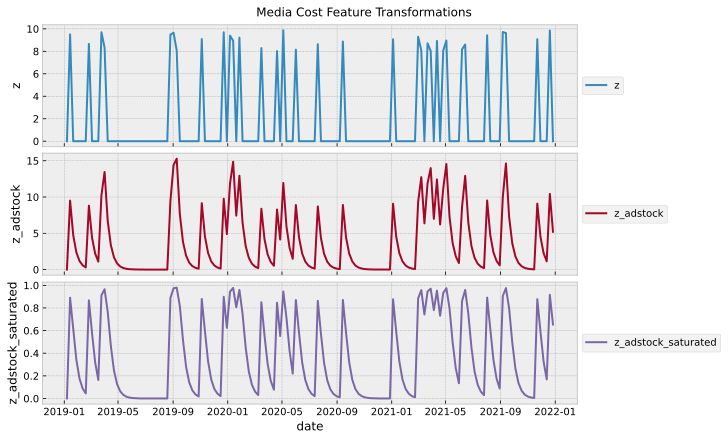

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")

features = ["z", "z_adstock", "z_adstock_saturated"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

### Trend and Seasonality

In [8]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 5)**(1/2) - 1 

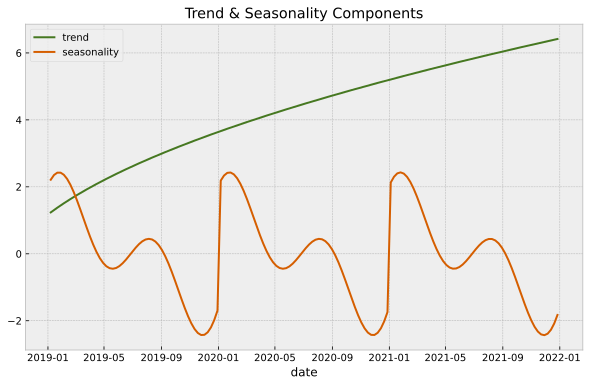

In [9]:
data_df["cs"] = np.sin(2 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["cc"] = np.cos(3 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["s"] = 2 * (data_df["cs"] + data_df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C3", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date", y="s", color="C4", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel="");

### Target Variable: Sales

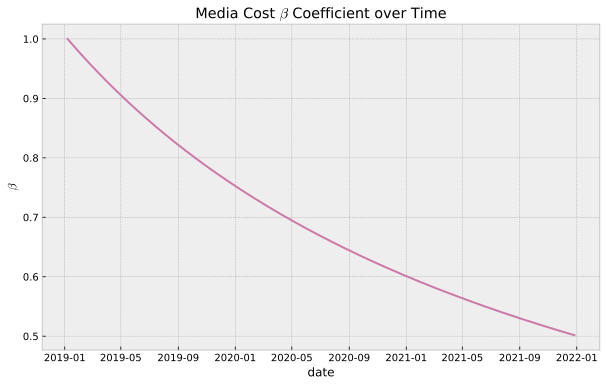

In [10]:
data_df["beta"] = 1 / (np.arange(start=0.0, stop=1.0, step=1/n) + 1)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="beta", color="C5", data=data_df, ax=ax)
ax.set(title="Media Cost $\\beta$ Coefficient over Time", ylabel="$\\beta$");

In [11]:
data_df["z_effect"] = data_df["beta"] * data_df["z_adstock_saturated"]

In [12]:
np.random.seed(SEED)

data_df["intercept"] = 10.0

data_df["epsilon"] = np.random.normal(loc=0.0, scale=0.8, size=n)

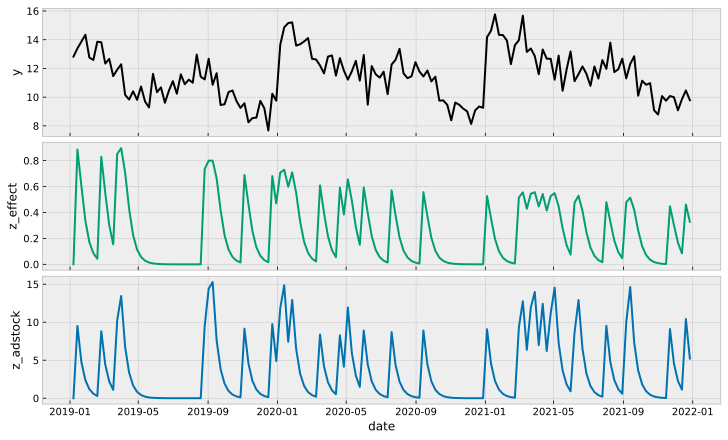

In [15]:
data_df["y"] = (
    np.log(data_df["trend"]) +
    data_df["s"] +
    data_df["z_effect"] +
    data_df["intercept"] +
    data_df["epsilon"]
)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=axes[0])
sns.lineplot(x="date", y="z_effect", color="C7", data=data_df, ax=axes[1])
sns.lineplot(x="date", y="z_adstock", color="C9", data=data_df, ax=axes[2])
ax.set(title="Target Variable - Sales");